#### Imports

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D

#### GPU Config

In [2]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(
                                    per_process_gpu_memory_fraction=0.8)
                                  # device_count = {'GPU': 1}
                                  )
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

### Datenset laden und vorbereiten

In [3]:
path = Path().resolve() / 'imdbdata.txt'
df = pd.read_csv(path, sep='\t', names=['review', 'label'], header=None)

# 0 == bad, 1 == good

print(df.head())
print(df['label'].unique())

review  label
0  A very, very, very slow-moving, aimless movie ...      0
1  Not sure who was more lost - the flat characte...      0
2  Attempting artiness with black & white and cle...      0
3       Very little music or anything to speak of.        0
4  The best scene in the movie was when Gerardo i...      1
[0 1]


Größe des Vokabulars bestimmen

In [4]:
# alle wörter klein schreiben (jeder Satz endet mit ' ')
text = (df['review'] + ' ').str.lower()

# bilde einen großen Text (alle einzelnen Texte zusammengefasst)
text = text.sum()
# spalte nach wörtern
text = np.array(text.split())
# anzahl der einzigartigen einträge
voc_size = len(np.unique(text))
print(voc_size)

4004


Encoding der Texte  
Alle Sequenzen auf gleiche Länge bringen

In [5]:
features = df['review'].apply(one_hot, args=[voc_size])
# print(features)

# print(features.apply(len).sort_values().tail(15))

b_len = features.apply(len) < 80

features = features[b_len]
target = df.loc[b_len, 'label']

maxlen = features.apply(len).max()

features = pad_sequences(features, maxlen=maxlen, padding='pre')

print(features)

[[   0    0    0 ... 1523 3810 1040]
 [   0    0    0 ...  785 2504 3120]
 [   0    0    0 ... 3369  486   36]
 ...
 [   0    0    0 ... 2463 1580 1092]
 [   0    0    0 ...    0 2989 1820]
 [   0    0    0 ... 1575 3682  908]]


### Modelierung

In [6]:
model = Sequential()
model.add(Embedding(voc_size + 1, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 73, 8)             32040     
_________________________________________________________________
flatten (Flatten)            (None, 584)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 585       
Total params: 32,625
Trainable params: 32,625
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test))

Epoch 1/100
20/20 [==============================] - 0s 10ms/step - loss: 0.6926 - acc: 0.5236 - val_loss: 0.6970 - val_acc: 0.4610
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6860 - acc: 0.5480 - val_loss: 0.6946 - val_acc: 0.4610
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6801 - acc: 0.5886 - val_loss: 0.6942 - val_acc: 0.4675
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6725 - acc: 0.5967 - val_loss: 0.6949 - val_acc: 0.4610
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6621 - acc: 0.6488 - val_loss: 0.6936 - val_acc: 0.4610
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.6488 - acc: 0.8098 - val_loss: 0.6912 - val_acc: 0.4935
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6316 - acc: 0.9187 - val_loss: 0.6898 - val_acc: 0.5195
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6108 - 

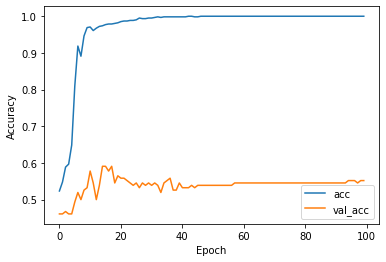

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
model = Sequential()

model.add(Embedding(voc_size + 1, 8, input_length=maxlen))
model.add(Conv1D(32, kernel_size=2, activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=2, activation='relu', padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test))

Epoch 1/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6920 - acc: 0.5187 - val_loss: 0.6965 - val_acc: 0.4610
Epoch 2/100
20/20 [==============================] - 0s 20ms/step - loss: 0.6914 - acc: 0.5268 - val_loss: 0.6965 - val_acc: 0.4610
Epoch 3/100
20/20 [==============================] - 0s 19ms/step - loss: 0.6906 - acc: 0.5268 - val_loss: 0.6946 - val_acc: 0.4610
Epoch 4/100
20/20 [==============================] - 0s 19ms/step - loss: 0.6847 - acc: 0.5252 - val_loss: 0.6952 - val_acc: 0.4610
Epoch 5/100
20/20 [==============================] - 0s 19ms/step - loss: 0.6583 - acc: 0.5317 - val_loss: 0.6783 - val_acc: 0.5260
Epoch 6/100
20/20 [==============================] - 0s 21ms/step - loss: 0.6112 - acc: 0.7138 - val_loss: 0.6501 - val_acc: 0.6299
Epoch 7/100
20/20 [==============================] - 0s 21ms/step - loss: 0.4622 - acc: 0.7935 - val_loss: 0.5820 - val_acc: 0.6688
Epoch 8/100
20/20 [==============================] - 0s 20ms/step - loss: 0.

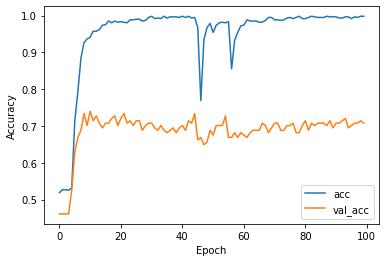

In [16]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()